In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/Soft_ass2/'

In [ ]:
dataset_A = url + 'Dataset A.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  19702


# **Base Parameters**

In [ ]:
batch_size = 100
num_iters = 40000
input_dim = 28*28
num_hidden = 800
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

203


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:158
Test dataloader:40


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=800, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=800, out_features=800, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=800, out_features=800, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=800, out_features=800, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=800, out_features=800, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=800, out_features=800, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=800, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration: 500. Loss: 2.3011512756347656. Accuracy: 9.263959390862944
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 1000. Loss: 2.299680471420288. Accuracy: 9.238578680203046
Epoch:  8
Epoch:  9
Epoch:  10
Iteration: 1500. Loss: 2.2906923294067383. Accuracy: 9.949238578680204
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 2000. Loss: 2.2139480113983154. Accuracy: 10.761421319796954
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 2500. Loss: 2.154277801513672. Accuracy: 20.101522842639593
Epoch:  17
Epoch:  18
Epoch:  19
Iteration: 3000. Loss: 2.200479507446289. Accuracy: 14.49238578680203
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Iteration: 3500. Loss: 2.463494300842285. Accuracy: 22.00507614213198
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 4000. Loss: 2.4219484329223633. Accuracy: 10.583756345177665
Epoch:  27
Epoch:  28
Epoch:  29
Iteration: 4500. Loss: 2.0379714965820312. Accuracy: 23.502538071065988
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 5000. Lo

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CSE4238/Offline_2/Models/model_base.pkl')

[2.3011512756347656, 2.299680471420288, 2.2906923294067383, 2.2139480113983154, 2.154277801513672, 2.200479507446289, 2.463494300842285, 2.4219484329223633, 2.0379714965820312, 2.1109542846679688, 1.9659048318862915, 1.9490327835083008, 1.9543511867523193, 2.144376039505005, 1.487282395362854, 1.647763729095459, 1.6645318269729614, 1.8803927898406982, 1.711030125617981, 1.3721355199813843, 1.9460577964782715, 2.001742362976074, 1.284866452217102, 1.451809287071228, 2.275972366333008, 1.1148309707641602, 1.5141171216964722, 0.9979556798934937, 0.8183618783950806, 1.1431275606155396, 0.7358543276786804, 0.860334038734436, 0.8654182553291321, 0.8394246697425842, 0.8102390170097351, 0.7432027459144592, 0.5809769034385681, 1.2588896751403809, 0.706529438495636, 1.7317743301391602, 0.7617414593696594, 0.47246071696281433, 0.4153774678707123, 0.6958394646644592, 0.7970740795135498, 0.667724609375, 0.29746213555336, 0.1916656345129013, 0.400600790977478, 0.34588584303855896, 0.2817310094833374

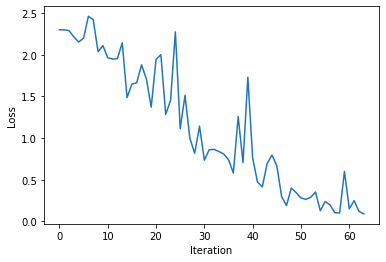

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()